# 종목별 테스트
 - 독립변수(모집단) : 기업이름으로 검색한 3~5월 사이의 뉴스데이터
 - 종속변수 : 뉴스의 발행 시점으로부터 종가가 몇 %상승했는가?

In [1]:
import os
import pandas as pd
import numpy as np
import glob
from newstock.news import Newstock

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [3]:
import sklearn.metrics as m

In [4]:
import matplotlib.pyplot as plt

In [5]:
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/gulim.ttc' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, text='text'):
        self.text = text

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.text]

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class Buy_Sell_transformer(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, cut_percent=0.01):
        self.cut_percent = cut_percent

    def fit(self, y):
        return self

    def transform(self, y):
        y = pd.cut(y, bins=[-np.inf, self.cut_percent, np.inf], labels=['nothing','buy'])
        return y

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test <= data[date_column].max().date() + eval('relativedelta('+self.freq+'=1)'):
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            print("Train period:",start_train,"<= day <" , end_train, ", Test period", start_test, "<= day <", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 

In [10]:
names = os.listdir('./stock_data/stock_article0301_0531/article/')

In [11]:
data = {}
for name in names:
    print(name)
    data[name] = Newstock(name).get_data_by_name()

KB금융
LG생활건강
LG화학
NAVER
POSCO
SK
SK텔레콤
SK하이닉스
기아차
삼성SDI
삼성물산
삼성바이오로직스
삼성에스디에스
삼성전자
셀트리온
신한지주
엔씨소프트
카카오
현대모비스
현대차


In [41]:
def run(x, y, train_period=60, test_period=29):
    y_process = Pipeline([
        ('Buy_Sell_transformer', Buy_Sell_transformer()),
    ])

    x_process = Pipeline([
        ('selector', TextSelector()),
        ('counter', CountVectorizer()),
    ])

    pipeline = Pipeline([
                    ('process', x_process),
                    ('clf', MultinomialNB())
                   ])
    
    tscv = TimeBasedCV(train_period=train_period, test_period=test_period, freq='days')
    cv_sets = tscv.split(x.reset_index(drop=True), validation_split_date=None, date_column='timestamps', gap=0)
    
    pipeline.fit(x.iloc[cv_sets[0][0]], y_process.transform(y).iloc[cv_sets[0][0]])
    
    y_true = y_process.transform(y).iloc[cv_sets[0][1]]
    y_pred_prob = pipeline.predict_proba(x.iloc[cv_sets[0][1]])[:, 0]
    y_pred = pipeline.predict(x.iloc[cv_sets[0][1]])
    
    fpr, tpr, _ = m.roc_curve(y_true, y_pred_prob, pos_label=['buy'])
    roc_auc = m.auc(fpr, tpr)

    roc = m.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')    
    conf = m.plot_confusion_matrix(pipeline, x.iloc[cv_sets[0][1]], y_true,
                                   display_labels=['buy', 'nothing'], normalize=None)
    
    return conf, roc

Train period: 2020-03-03 <= day < 2020-05-02 , Test period 2020-05-02 <= day < 2020-05-28 # train records 32 , # test records 17


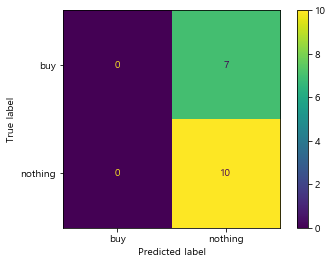

In [80]:
x, y = data["삼성에스디에스"]
conf, roc = run(x, y, train_period=60, test_period=26)

Text(0.5, 1.0, '삼성에스디에스')

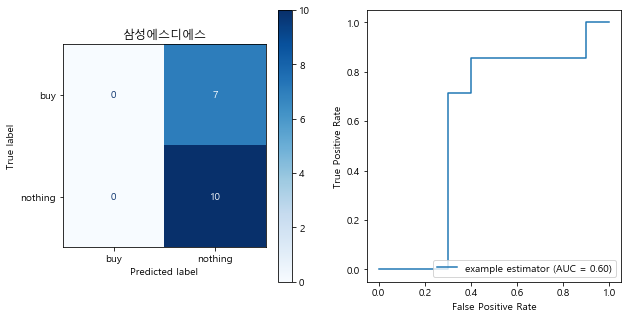

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

roc.plot(ax=ax[1])
conf.plot(ax=ax[0], cmap=plt.cm.Blues)
ax[0].set_title("삼성에스디에스")

현대차
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 2378 , # test records 894
카카오
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 2225 , # test records 1256
KB금융
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 593 , # test records 158
LG생활건강
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 735 , # test records 272
NAVER
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 393 , # test records 239
셀트리온
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 1215 , # test records 504
삼성물산
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 1015 , # test records 517
엔씨소프트
Train period: 2020-03-02 <= day < 20

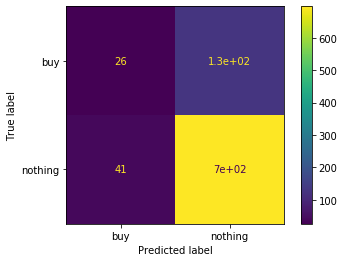

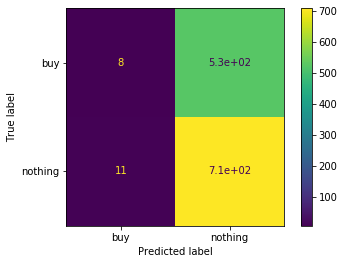

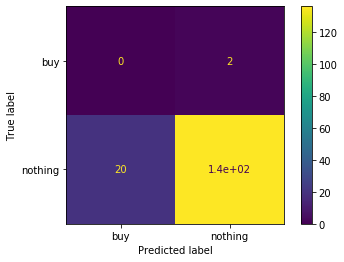

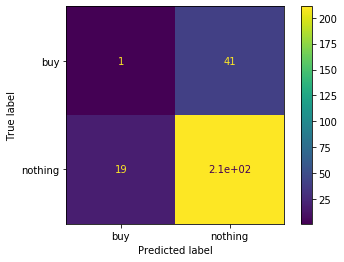

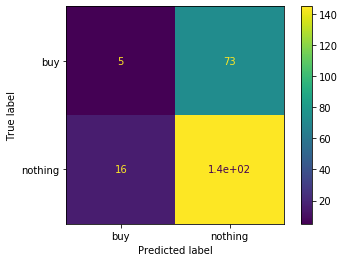

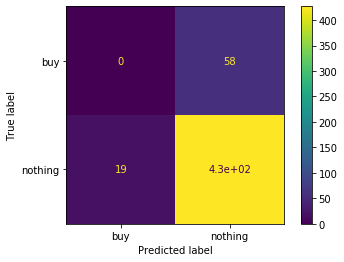

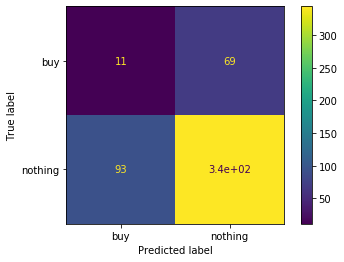

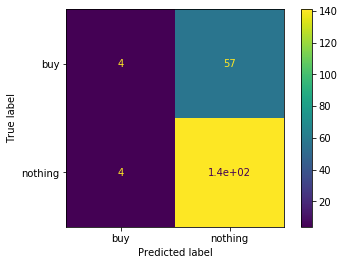

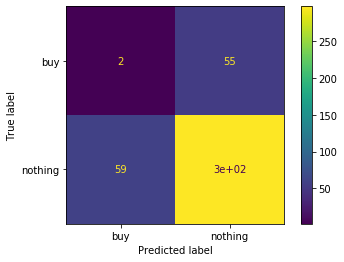

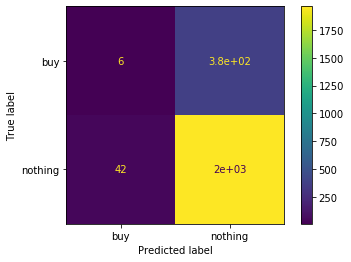

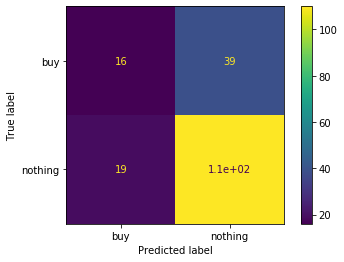

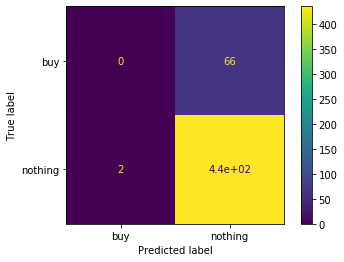

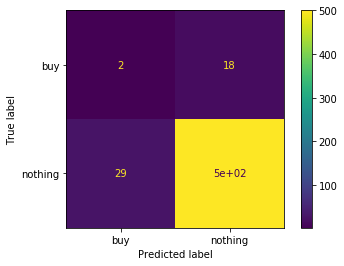

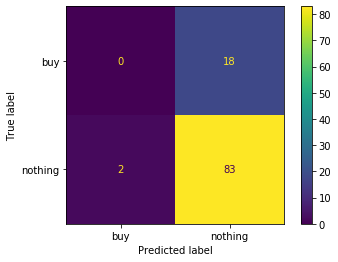

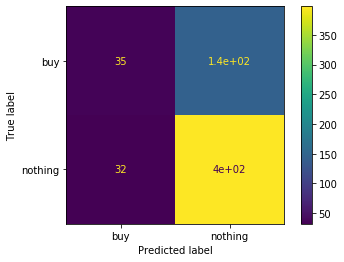

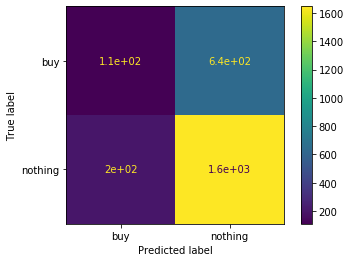

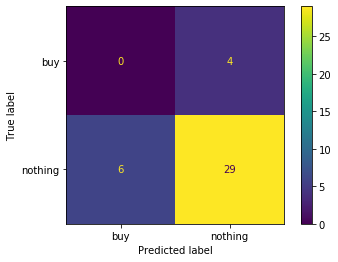

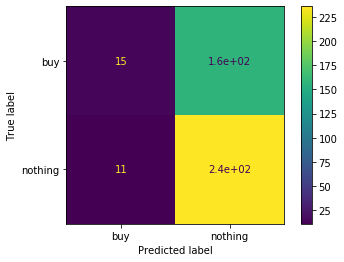

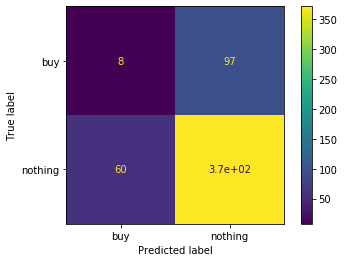

In [48]:
confs = []
rocs = []

keys = set(data.keys())-set(['삼성에스디에스'])

for name in keys:
    print(name)
    x, y = data[name]
    conf, roc = run(x, y)
    confs.append(conf)
    rocs.append(roc)

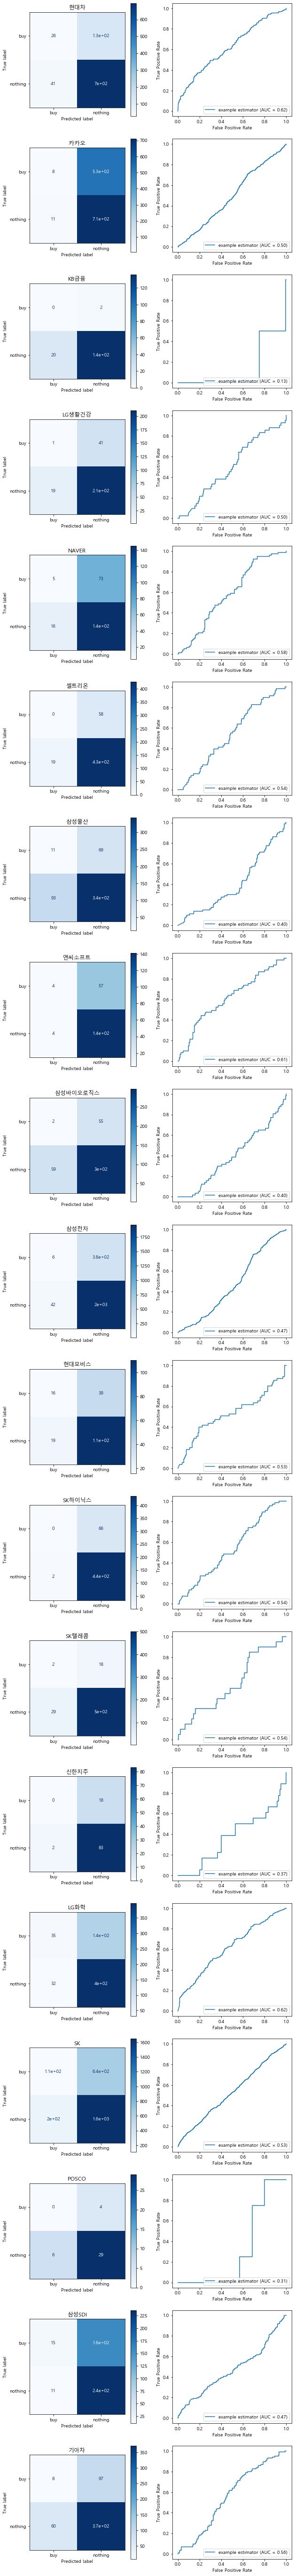

In [61]:
fig, ax = plt.subplots(len(confs), 2, figsize=(10, 100))

for i, key in enumerate(keys):
    rocs[i].plot(ax=ax[i][1])
    confs[i].plot(ax=ax[i][0], cmap=plt.cm.Blues)
    ax[i][0].set_title(key)

현대차
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 2378 , # test records 894
SK
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 4978 , # test records 2598
카카오
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 2225 , # test records 1256
NAVER
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 393 , # test records 239
엔씨소프트
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 242 , # test records 206
현대모비스
Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 539 , # test records 184


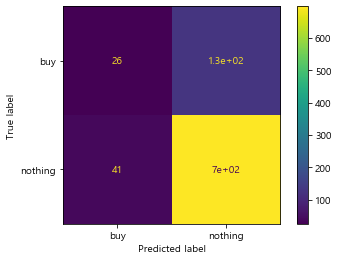

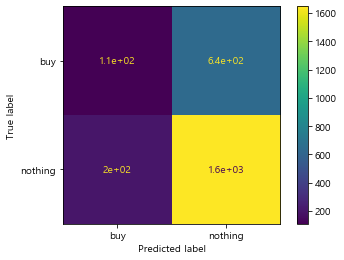

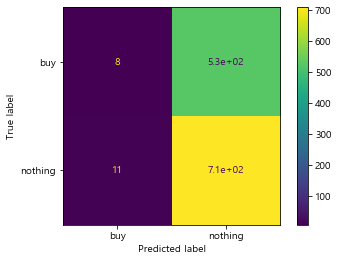

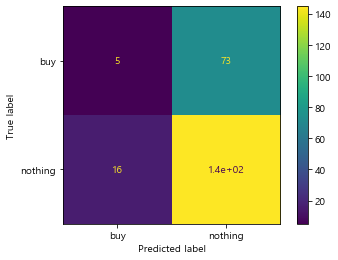

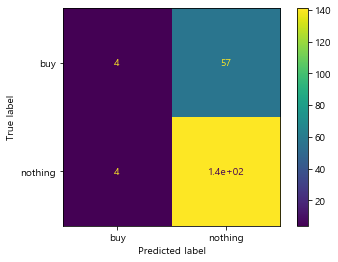

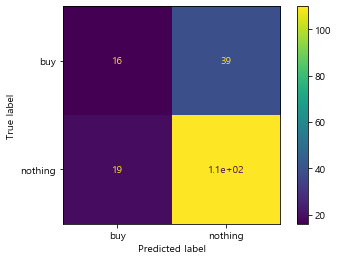

In [74]:
confs = []
rocs = []

keys = ['현대차', "SK", "카카오", "NAVER", "엔씨소프트", "현대모비스"]

for name in keys:
    print(name)
    x, y = data[name]
    conf, roc = run(x, y)
    confs.append(conf)
    rocs.append(roc)

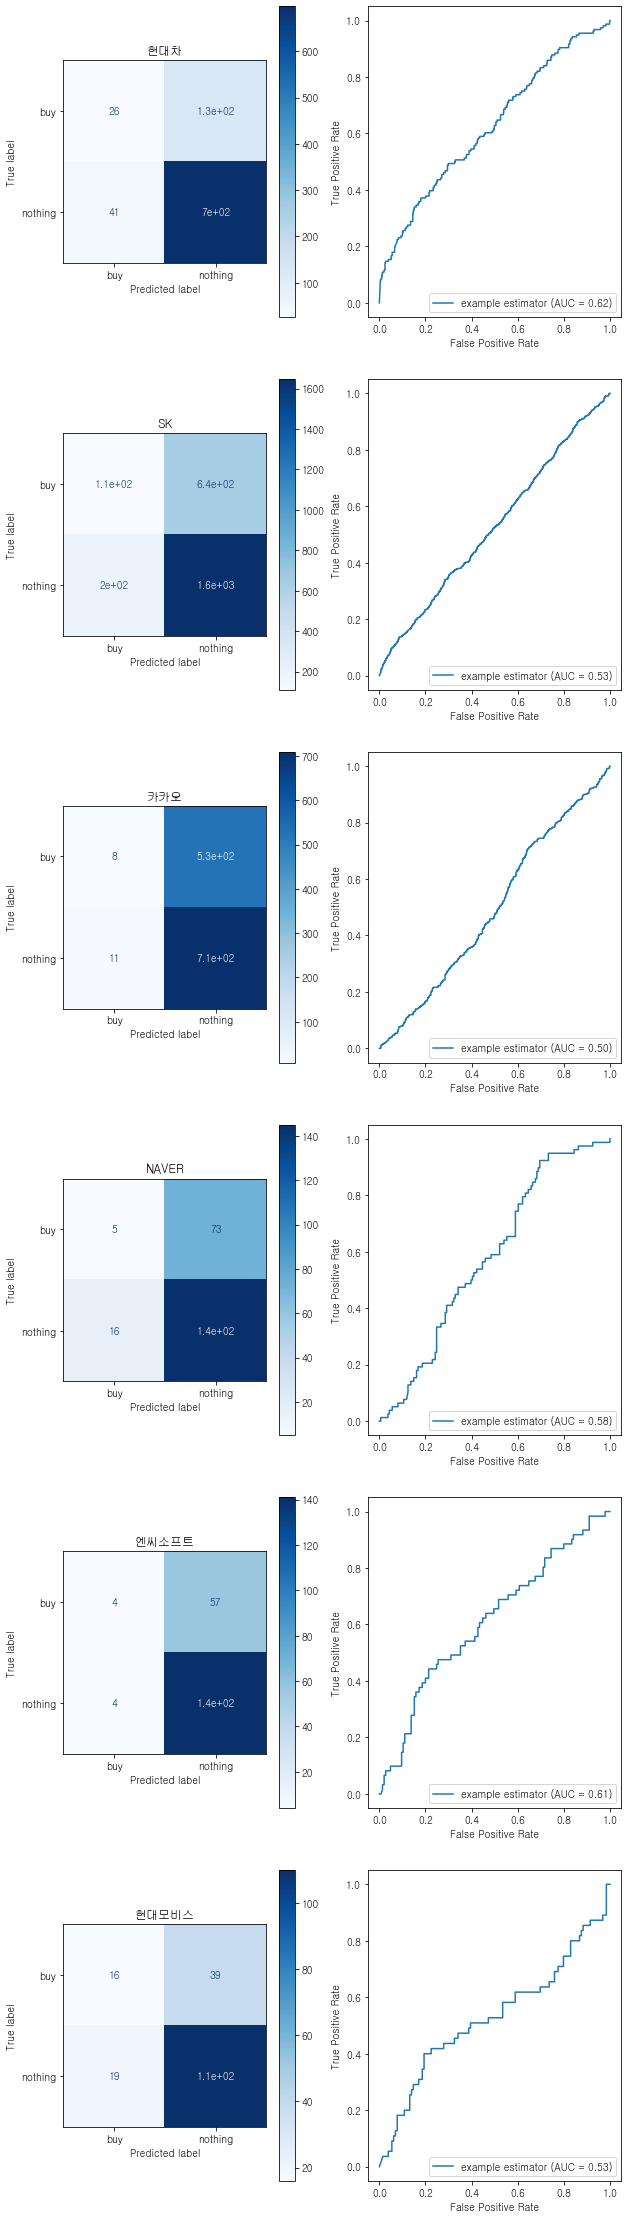

In [92]:
fig, ax = plt.subplots(len(confs), 2, figsize=(10, 40))

for i, key in enumerate(keys):
    rocs[i].plot(ax=ax[i][1])
    confs[i].plot(ax=ax[i][0], cmap=plt.cm.Blues)
    ax[i][0].set_title(key)

# 전체 뉴스데이터 종합

C:\Users\ufoio\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 26608 , # test records 12408


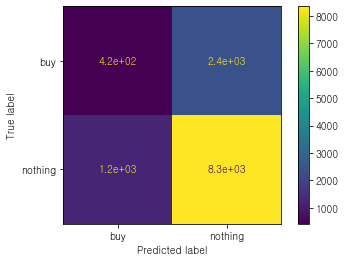

In [269]:
x_all = pd.DataFrame()
y_all = pd.Series().astype(float)

for key in data.keys():
    x_tmp, y_tmp = data[key]
    x_all = x_all.append(x_tmp)
    y_all = y_all.append(y_tmp)
    
conf, roc = run(x_all, y_all)

Text(0.5, 1.0, '전체')

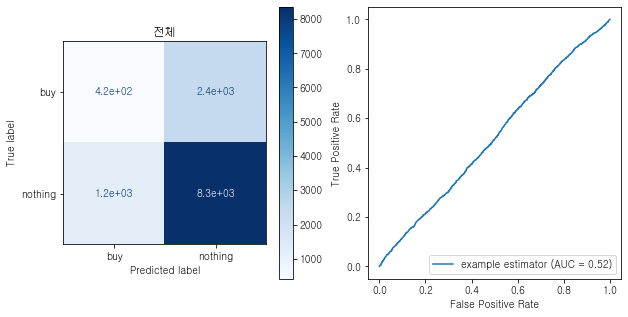

In [272]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

roc.plot(ax=ax[1])
conf.plot(ax=ax[0], cmap=plt.cm.Blues)
ax[0].set_title("전체")

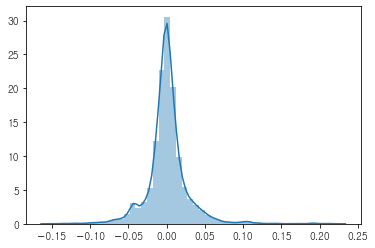

In [273]:
sns.distplot(y_all)

# 개별 주식 분석

In [85]:
import seaborn as sns

In [86]:
hx, hy = data['현대차']

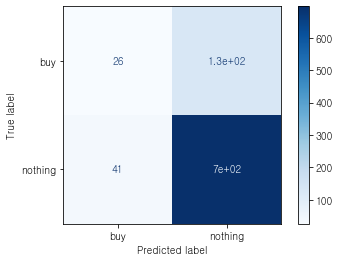

In [97]:
confs[0].plot(cmap=plt.cm.Blues)

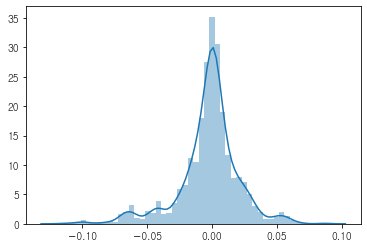

In [93]:
sns.distplot(hy)

## 현대차 뉴스데이터 단어 조사?

In [106]:
y_process = Pipeline([
    ('Buy_Sell_transformer', Buy_Sell_transformer()),
])

x_process = Pipeline([
    ('selector', TextSelector()),
    ('counter', CountVectorizer()),
])

pipeline = Pipeline([
                ('process', x_process),
                ('clf', MultinomialNB())
               ])

tscv = TimeBasedCV(train_period=60, test_period=29, freq='days')
cv_sets = tscv.split(hx.reset_index(drop=True), validation_split_date=None, date_column='timestamps', gap=0)

pipeline.fit(hx.iloc[cv_sets[0][0]], y_process.transform(hy).iloc[cv_sets[0][0]])

Train period: 2020-03-02 <= day < 2020-05-01 , Test period 2020-05-01 <= day < 2020-05-30 # train records 2378 , # test records 894


Pipeline(memory=None,
         steps=[('process',
                 Pipeline(memory=None,
                          steps=[('selector', TextSelector(text='text')),
                                 ('counter',
                                  CountVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.int64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=None, min_df=1,
                                                  ngram_range=(1, 1),
                                                  preprocessor=None,
                                                  stop_words=None,
                                                  strip_accen

### 확률이 높은 순

In [115]:
pos_class_prob_sorted = pipeline.get_params()['steps'][1][1].feature_log_prob_[1, :].argsort()
neg_class_prob_sorted = pipeline.get_params()['steps'][1][1].feature_log_prob_[0, :].argsort()

In [219]:
count_vectorizer = pipeline.steps[0][1].steps[1][1]

In [220]:
pos_words = np.take(count_vectorizer.get_feature_names(), pos_class_prob_sorted)
neg_words = np.take(count_vectorizer.get_feature_names(), neg_class_prob_sorted)

In [275]:
pos_words[:100]

array(['업체들을', '분석기관인', '과세하고', '남성이었다', '찍어', '찍던', '분석되는데요', '40시간에',
       '이성원', '남성비율이', '남성보다', '분석으로', '쪽에선', 'nature', '분석하면', '쪽도',
       '분식회계', '40조9912억원으로', '40만주를', '찍히는', '차감한다', '분석결과',
       '408억5000만원으로', '408억5천만', '이상이고', '이상이다', '남았는데', '4099억원의',
       '분산돼', 'ndf', '쪼그라들', '차남', 'ncc공정과', '차급의', '차급은', '이상이었고', '분산해',
       '분산해서', '과세대상이니', '40만t씩', '이상이면서도', '남양넥스모', '이송렬', 'm이며', '날짜에',
       '413억원', '4144억원어치와', '짙어지고', '4165억워어치의', '과열해소', '날짜는', '징후는',
       '시그널을', '417억원을', '짓은', '짓습니다', '짓던', '날인데', '41p', '분쟁이나', '날이',
       '이슈라는', '시급성과', '남겨', '시기까지', '남다른', '시기상조라며', '남는다', '짝수해에',
       '이순자', 'm와', '분양올해', '이순자씨', '40조원이', '시기도', '분위기도', '짜리',
       '411억여원', '과열되면서', '짜놓은', '4124억원', '과열된', 'mx', '분위기까지', '짓기',
       '차단해야', '406억원을', '분기마다', '시도에도', '납입됐다', '시도됐다', '4000만원',
       '차시장에서', '시도도', '차선유지기능을', '차선변경을', '차분히', '차분한', '차부품업계를', 'nh선물'],
      dtype='<U38')

In [277]:
neg_words[:100]

array(['ｍ의', '박시진기자', '박연차', '주가까지', '박영래', '박영우', '박영준', '박용만', '박용철',
       '주60시간', '박승원입니다', '박원순', '박윤호기자', '박은석', '박은하', '박응진', '박일준',
       '박자연', '박재구', '박정국', '박정림', '박유진', '박승원', '주가로', '박승영', '박민주기자',
       '박사는', '주가순수익비율', '박삼구', '주가수익비율', '박상모', '박상용', '박상현', '박상홍',
       '박석중', '주가수익률', '박세영', '박세준', '주가상승은', '주가상승에', '주가상승률을', '주가보다',
       '박스', '박스권', '주가방어에', '박스오피스', '박정수', '주40시간', '박정일', '박정일기자',
       '박효정기자', '좌초', '좌우했는지', '좌우할', '밖으로도', '밖의', '좌우될', '반가운', '반감은',
       '반값', '좌우되는', '반값임금', '반값임금으로', '반격을', '반격의', '반격이', '반겼다',
       '반겼습니다', '반경', '반기는', '반기를', '좌초가', '박모씨는', '좌초되는', '박혜진', '주3일',
       '박정훈', '박종대', '주2회', '죄인', '죄기', '박준규', '박지', '박지성', '박지성입니다',
       '박지영', '좌회전할', '좌파', '박진형', '박차5', '박철홍', '박탈감을', '박태진', '박한신기자',
       '좌초되면', '박현', '박호석', '좌시하지', '박람회인', '박대로'], dtype='<U38')

In [221]:
vector_test_hx = count_vectorizer.transform(hx['text'].iloc[cv_sets[0][1]])

In [222]:
word = pos_words[230]
col_n = count_vectorizer.vocabulary_[word]

print(word)
hx.iloc[cv_sets[0][1]].reset_index(drop=True)[pd.DataFrame(vector_test_hx.toarray()).iloc[:, col_n] > 0]

불참하고


,title,url,press,summary,head,text,timestamps,체결시간,현재가,시가,고가,저가,거래량,date,time,end_price


In [227]:
pd.DataFrame(vector_test_hx.toarray()).sum().sort_values().index

Int64Index([38295, 46478, 46479, 46480, 46481, 46482, 46484, 46485, 46486,
            46487,
            ...
            36071, 63663, 58299, 23157, 56831, 18392, 68375, 24157, 74378,
            56846],
           dtype='int64', length=76591)

### 많이 나온 단어순

In [223]:
many_words = np.take(count_vectorizer.get_feature_names(), list(pd.DataFrame(vector_test_hx.toarray()).sum().sort_values().index))

In [280]:
many_words[-100:]

array(['대해', '기업', '이상', '지수는', '이재용', '전년', '삼성', '사장', '코스피', '에서',
       '오전', '감염증', '상위', '것이다', '판매', '것은', 'suv', '정의선', '현대차의', '코로나',
       '모두', '기준', '시장', '가장', '현대차그룹', '반면', '미래', '따라', '등은', '계획이다',
       '관련', '이어', '개발', '차세대', '예정이다', '시가총액', '1분기', '오른', '신종', '중이다',
       '3월', '중국', '경우', '세계', '모빌리티', '다양한', '서울', '가운데', '주요', '특히',
       '했다', '같은', '삼성sdi', '삼성전자', '전재', '무단', '최근', '등을', '수소', '함께',
       '따르면', '현재', '이후', '현대', '기아차', '각각', 'com', '관계자는', '지난해', '등이',
       '이날', '자동차', '대비', '이번', '말했다', '미국', '이라고', '밝혔다', '무단전재', '대한',
       'co', 'kr', '위한', '현대차는', '글로벌', '올해', '전기차', '위해', '국내', '통해',
       '배터리', '지난', '재배포', '금지', '있는', '것으로', '코로나19', '기자', '현대차', '있다'],
      dtype='<U38')

In [233]:
word = many_words[-5]
col_n = count_vectorizer.vocabulary_[word]

print(word)
hx.iloc[cv_sets[0][1]].reset_index(drop=True)[pd.DataFrame(vector_test_hx.toarray()).iloc[:, col_n] > 0]

것으로


,title,url,press,summary,head,text,timestamps,체결시간,현재가,시가,고가,저가,거래량,date,time,end_price
0,25조 쏟아부은 동학개미 성적표는-지수 반등폭(코스피 최저점 대비 32.7%)과 ...,/news/news_read.nhn?article_id=0000065305&offi...,매경이코노미,소위 테마주라 불리는 급등주에 몰렸던 금융위기 때와는 달리 2020년 개미들은 삼성...,NaN,코로나19 사태를 계기로 개인투자자에 대한 인식이 달라지고 있다. 국내 증시에서 개...,2020-05-04 09:12:00,2.020050e+13,91100.0,91100.0,91100.0,91000.0,6447.0,2020-05-04,09:12:00,91500
1,자동차업계 4월 판매 '암울'…현대·기아 美 판매 40% 줄어,/news/news_read.nhn?article_id=0009844775&offi...,뉴시스,4일 업계와 외신 등에 따르면 현대차와 기아차의 4월 미국 판매 실적이 지난해 같은...,NaN,[서울=뉴시스] 박주연 기자 = 완성차업계가 우울한 4월 성적표를 받아들 전망이다....,2020-05-04 09:16:00,2.020050e+13,91400.0,91200.0,91400.0,91200.0,3754.0,2020-05-04,09:16:00,91500
3,닻올린 현대차 세대교체…총수로 '정몽구 회장' 유지된 까닭은,/news/news_read.nhn?article_id=0000536722&offi...,아이뉴스24,정의선 현대차그룹 수석부회장이 현대차 이사회 의장직을 물려받으며 세대교체가 공식화됐...,"""정몽구 회장, 지배력 여전""…회사측 '세대교체론' 선 그어",[아이뉴스24 이연춘 기자] 정의선 현대차그룹 수석부회장이 현대차 이사회 의장직을 ...,2020-05-04 09:18:00,2.020050e+13,91500.0,91500.0,91600.0,91400.0,9650.0,2020-05-04,09:18:00,91500
4,"[마켓인사이트]""한국이 세계 최고가 될 수 있는 분야""...산업 AI에 투자하는 ...",/news/news_read.nhn?article_id=0004334249&offi...,한국경제,"전문 벤처 투자가인 벤처캐피탈(VC)뿐 아니라 삼성, LG, 현대차, SK텔레콤, ...",≪이 기사는 04월17일(06:37) 자본시장의 혜안 ‘마켓인사이트’에 게재된 기사...,생산 현장에서 발생하는 데이터를 인공지능(AI) 기술로 분석해 생산성을 높여주는 산...,2020-05-04 09:18:00,2.020050e+13,91500.0,91500.0,91600.0,91400.0,9650.0,2020-05-04,09:18:00,91500
12,삼성전자 2분기 전망 줄하향…영업익 6조원 밑 예상도,/news/news_read.nhn?article_id=0001669230&offi...,헤럴드경제,한국투자증권과 현대차증권도 2분기 영업이익 눈높이를 낮췄다. 한국투자증권은 지난달보...,"신한·유안타·한투·현대차 등하이투자증권 ""급락시마다 조금씩 저점매수""KTB투자증권 ...",[헤럴드경제=김현경 기자] 증권사들이 삼성전자의 2분기 실적 전망을 잇따라 내려잡고...,2020-05-04 10:26:00,2.020050e+13,91800.0,91900.0,91900.0,91700.0,2145.0,2020-05-04,10:26:00,91500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,[우리동네 지역전문가] 현대차 GBC 사업 본격화… ‘강남구 삼성동’ 대형 호재는...,/news/news_read.nhn?article_id=0004584248&offi...,매일경제,"지난 6일, 현대차그룹은 서울시로부터 글로벌비즈니스센터(GBC)의 착공 신고필증을 ...",NaN,"대한민국의 마천루가 바뀔 전망이다. 지난 6일, 현대차그룹은 서울시로부터 글로벌비즈...",2020-05-28 15:19:00,2.020053e+13,97500.0,97500.0,97600.0,97400.0,2723.0,2020-05-28,15:19:00,97200
879,"한국가스공사, 저평가지만 매수는 뒤로-현대차證",/news/news_read.nhn?article_id=0004416694&offi...,머니투데이,현대차증권이 29일 한국가스공사에 대해 장기적인 저점을 확인했지만 불확실성이... ...,NaN,[머니투데이 조준영 기자] 현대차증권이 29일 한국가스공사에 대해 장기적인 저점을 ...,2020-05-29 09:37:00,2.020053e+13,97300.0,97300.0,97400.0,97300.0,599.0,2020-05-29,09:37:00,98000
883,재택근무 카드 꺼낸 최태원·신동빈 회장…재계 확산하나,/news/news_read.nhn?article_id=0000540588&offi...,아이뉴스24,현대차는 최근 클럽이나 주점 등 다중이용시설을 방문한 뒤 코로나19 의심증상이 나타...,"곳곳서 ""코로나19 확진자 증가하자 상황 예의주시""","[아이뉴스24 이연춘 기자] ""근무 환경 변화에 따라 일하는 방식도 당연히 바뀌어야...",2020-05-29 10:50:00,2.020053e+13,97600.0,97500.0,97700.0,97500.0,4385.0,2020-05-29,10:50:00,98000
884,네이버·카카오 이유있는 주가 강세,/news/news_read.nhn?article_id=0004687945&offi...,아시아경제,이밖에 현대차도 2분기 영업이익 컨센서스가 한 달 전에 비해 16.18% 낮아지며 ...,NaN,[아시아경제 송화정 기자]신종 코로나바이러스감염증(코로나19)으로 기업들의 올해 2...,2020-05-29 11:03:00,2.020053e+13,97400.0,97500.0,97600.0,97400.0,2570.0,2020-05-29,11:03:00,98000
